In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import kagglehub


In [ ]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
csv_path = os.path.join(path, "Data", "features_3_sec.csv")
df = pd.read_csv(csv_path)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
print("Dataset has",df.shape)

Dataset has (9990, 60)


Pre-process data

In [ ]:
X = df.drop(['filename', 'length', 'label'], axis=1, errors='ignore')
y = df['label']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Reshape input for LSTM: [samples, timesteps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


Training samples: (7992, 1, 57)
Testing samples: (1998, 1, 57)


In [ ]:

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 1, 256)         │       321,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,458 (2.05 MB)

 Trainable params: 536,458 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3404 - loss: 1.9844 - val_accuracy: 0.5591 - val_loss: 1.2002
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5779 - loss: 1.1704 - val_accuracy: 0.6823 - val_loss: 0.9194
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6917 - loss: 0.8988 - val_accuracy: 0.7205 - val_loss: 0.7800
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7303 - loss: 0.7727 - val_accuracy: 0.7642 - val_loss: 0.6716
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7665 - loss: 0.6642 - val_accuracy: 0.7836 - val_loss: 0.6196
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8011 - loss: 0.6029 - val_accuracy: 0.7942 - val_loss: 0.5886
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8235 - loss: 0.5457 - val_accuracy: 0.8124 - val_loss: 0.5619
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8266 - loss: 0.5090 - val_accu

Train model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")


63/63 - 0s - 6ms/step - accuracy: 0.8924 - loss: 0.5251
Test Accuracy: 89.24%


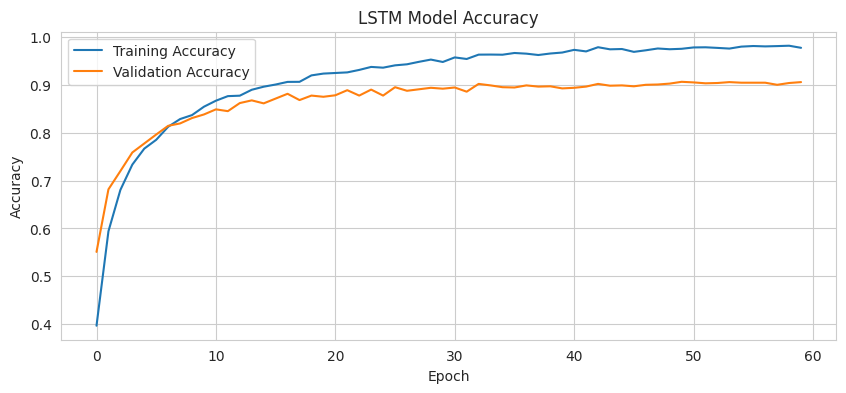

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📋 Classification Report:

              precision    recall  f1-score   support

       blues       0.94      0.91      0.92       200
   classical       0.90      0.97      0.93       199
     country       0.85      0.85      0.85       199
       disco       0.89      0.85      0.87       200
      hiphop       0.90      0.89      0.89       200
        jazz       0.88      0.90      0.89       200
       metal       0.94      0.92      0.93       200
         pop       0.90      0.88      0.89       200
      reggae       0.88      0.92      0.90       200
        rock       0.87      0.86      0.87       200

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



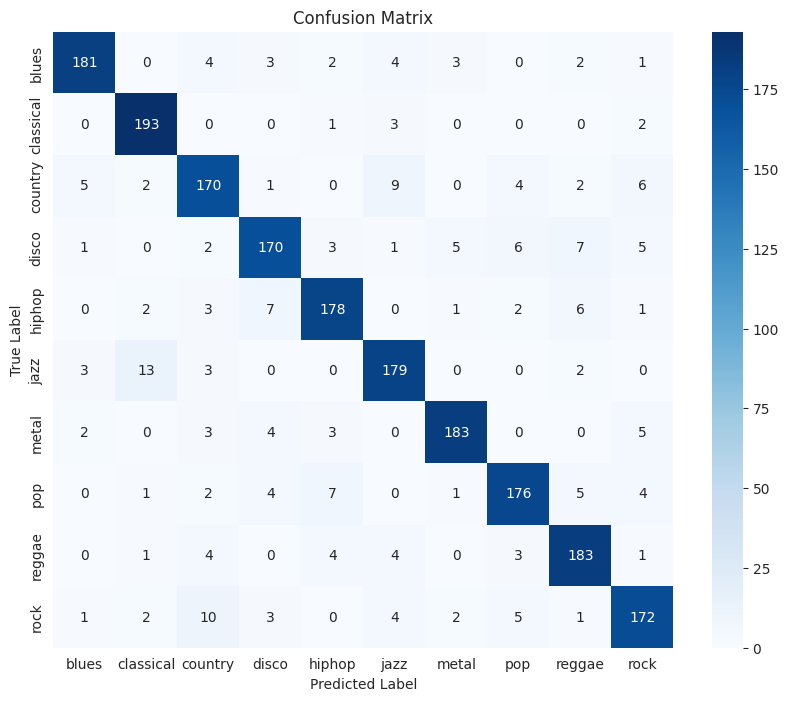

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=encoder.classes_))

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Path to test audio file
test_audio_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00000.wav"

# Feature extraction (should match training feature structure)
def extract_features_for_lstm(file_path, n_mfcc=57):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

# Extract and preprocess features
test_features = extract_features_for_lstm(test_audio_path)

# Scale using the same scaler fitted on training data
test_features_scaled = scaler.transform([test_features])

# Reshape for LSTM input
test_features_reshaped = np.reshape(test_features_scaled, (1, 1, X_train.shape[2]))

# Predict genre
pred = model.predict(test_features_reshaped)
predicted_genre = encoder.inverse_transform([np.argmax(pred)])

print(f"🎶 Predicted Genre: {predicted_genre[0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
🎶 Predicted Genre: jazz
